_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pyjanitor

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [3]:
# === Scope out dataset === #
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [4]:
df.isnull().sum()
# No null values

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
game_date                  0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

In [5]:
# === Target distribution === #
df["shot_made_flag"].value_counts()

0    7357
1    6601
Name: shot_made_flag, dtype: int64

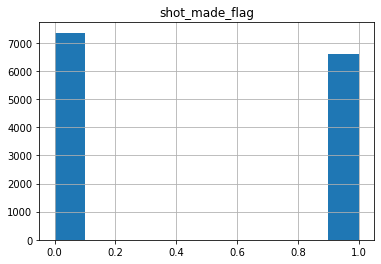

In [6]:
# The target is actually fairly evenly distributed!
df.hist("shot_made_flag");

## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [7]:
# === Majority class baseline === #
# Simply divide the count of majority class by the total
bass_acc = df["shot_made_flag"].value_counts()[0] / len(df["shot_made_flag"])
print(f"Majority class baseline accuracy: {bass_acc}")

Majority class baseline accuracy: 0.5270812437311936


In [8]:
# Or, create preds array to use in accuracy_score method
from sklearn.metrics import accuracy_score
bass_preds = [0] * len(df["shot_made_flag"])
bass_acc = accuracy_score(df["shot_made_flag"], bass_preds)
print(f"Majority class baseline accuracy: {bass_acc}")

Majority class baseline accuracy: 0.5270812437311936


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [9]:
# === Convert game_date to datetime === #
df["game_date"] = pd.to_datetime(df["game_date"])
df["game_date"]

0       2009-10-28
1       2009-10-28
2       2009-10-28
3       2009-10-28
4       2009-10-28
           ...    
13953   2019-06-05
13954   2019-06-05
13955   2019-06-05
13956   2019-06-05
13957   2019-06-05
Name: game_date, Length: 13958, dtype: datetime64[ns]

In [0]:
# === Import numpy to work with datetime === #
import numpy as np

In [11]:
# === Split test by season 18-19 === #
start_date = np.datetime64("2018-09-01")
end_date = np.datetime64("2019-08-01")

# end_date is not completely necessary,
# as the season in question is the final season in the data
train = df[df["game_date"] < start_date]
test = df[df["game_date"] > start_date]

train.shape, test.shape

((12249, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [12]:
# === Look back at the training data === #
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


I think it would be interesting to engineer the feature `made_prev_shot_`, as that requires some creative indexing.

In [13]:
# === Feature engineering: `made_prev_shot` === #

# Create new feature `made_prev_shot` as all 0s
# Loop through rows
# If first row, leave as 0
# Proceeding rows: set to value at index - 1

# Or, use Series.shift()...
def create_shift_col(data: pd.DataFrame, col: str, new_col: str):
    """Creates new column from shifted values of another."""
    data[new_col] = data[col].shift(1, axis=0, fill_value=0)

create_shift_col(train, "shot_made_flag", "made_prev_shot")
create_shift_col(test, "shot_made_flag", "made_prev_shot")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# === Feature engineering, part 2: "home_game" === #
# def home_game(data: pd.DataFrame):
#     """Engineers the home_game feature."""
#     data["home_game"] = data["htm"] == "GSW"

def home_game(cell):
    """Engineers the home_game feature."""
    return 1 if cell == "GSW" else 0

train["home_game"] = train["htm"].apply(home_game)
test["home_game"] = test["htm"].apply(home_game)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [15]:
train.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,made_prev_shot,home_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,0,1


In [16]:
# === Drop unneeded columns === #
drop_cols = [
    "game_id",
    "game_event_id",
    "player_name",
    "htm",
]

train = train.drop(columns=drop_cols)
test = test.drop(columns=drop_cols)

train.head()

,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,vtm,season_type,scoremargin_before_shot,made_prev_shot,home_game
0,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,HOU,Regular Season,2.0,0,1
1,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,HOU,Regular Season,0.0,0,1
2,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,HOU,Regular Season,-4.0,1,1
3,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,HOU,Regular Season,-4.0,0,1
4,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,HOU,Regular Season,0.0,0,1


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

### _I will be using cross-validation_

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [17]:
# === Look at cardinality === #
train.describe(exclude="number").T.sort_values(by="unique")

,count,unique,top,freq,first,last
shot_type,12249,2,2PT Field Goal,6446,NaT,NaT
season_type,12249,2,Regular Season,10506,NaT,NaT
shot_zone_range,12249,5,24+ ft.,5719,NaT,NaT
shot_zone_area,12249,6,Center(C),5331,NaT,NaT
shot_zone_basic,12249,7,Above the Break 3,4849,NaT,NaT
vtm,12249,32,GSW,6197,NaT,NaT
action_type,12249,52,Jump Shot,5916,NaT,NaT
game_date,12249,713,2013-05-06 00:00:00,35,2009-10-28,2018-06-08


Looks like there will be some ordinal encoding needed for the high-cardinality features...unless they are just dropped.

But I'll try using the ordinal encoder first.

In [18]:
# === Ordinal Encoding === #
import category_encoders as ce

oe = ce.OrdinalEncoder(cols=["vtm", "action_type"])

train = oe.fit_transform(train)
test = oe.fit_transform(test)

train.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,vtm,season_type,scoremargin_before_shot,made_prev_shot,home_game
0,1,11,25,1,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,1,Regular Season,2.0,0,1
1,1,9,31,2,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,1,Regular Season,0.0,0,1
2,1,6,2,1,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,1,Regular Season,-4.0,1,1
3,2,9,49,1,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,1,Regular Season,-4.0,0,1
4,2,2,19,1,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,1,Regular Season,0.0,0,1


In [0]:
# === Pipeline imports === #
import category_encoders as ce
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [0]:
# === Arrange X and y === #
# Also remove game_date because datetime datatype
X_train = train.drop(columns=["shot_made_flag", "game_date"])
X_test = test.drop(columns=["shot_made_flag", "game_date"])

y_train = train[["shot_made_flag"]]
y_test = test[["shot_made_flag"]]


In [21]:
# === Pipeline build === #
from scipy.stats import randint, uniform

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestClassifier(),
)

param_distributions = {
    "randomforestclassifier__n_estimators": randint(50, 500),
    "randomforestclassifier__max_depth": [5, 10, 15, 20, 25, None],
    "randomforestclassifier__max_features": uniform(0, 1),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=8,
    cv=3,
    scoring="accuracy",
    verbose=10,
    return_train_score=True,
    n_jobs=-1,
)

search.fit(X_train, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('standardscaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
   

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [22]:
print("Best hyperparameters:", search.best_params_)
print("Cross-validation accuracy:", search.best_score_)

Best hyperparameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.42566891283732355, 'randomforestclassifier__n_estimators': 493}
Cross-validation accuracy: 0.6609519144419952


## 7. Get your model's test accuracy

> (One time, at the end.)

In [23]:
from sklearn.metrics import accuracy_score

model = search.best_estimator_

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Test accuracy:", acc)

Test accuracy: 0.6214160327677004


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [24]:
# === Accuracy === #
# Accuracy is the number of correct predictions (left diagonal)
# over the total number of predictions (all cells)
correct_preds = 85 + 36
total_preds = correct_preds + 8 + 58
accuracy = correct_preds / total_preds
accuracy

0.6470588235294118

### Calculate precision

In [26]:
# === Precision === #
# Precision is the number of true positives
# over the total number of positives
true_pos = 36
total_pos = true_pos + 58

precision = true_pos / total_pos
precision

0.3829787234042553

### Calculate recall

In [27]:
# === Recall === #
# Recall is the number of true positives
# over the number of actual positives
true_pos = 36
actual_pos = true_pos + 8

recall = true_pos / actual_pos
recall

0.8181818181818182